***Importing Libraries***

In [2]:
# importing necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import networkx as nx
import networkx.algorithms.community as nx_comm
import community.community_louvain as community_louvain
import warnings

In [3]:
# Ignore all warnings
warnings.filterwarnings('ignore')

***Database Connection***

In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('accident_data_v1.0.0_2023.db')
# Creating the cursor object
cursor = conn.cursor()
# Check the available tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
# Displaying the tables with this line of codes
print("Tables in the database:", tables)

Tables in the database: [('accident',), ('casualty',), ('vehicle',), ('lsoa',)]


In [5]:
# Gettign table infos and summaries
table_names = ['accident', 'casualty', 'vehicle', 'lsoa']
# Fetch column names with a for loop
for table_name in table_names:   
    table_summaries = pd.read_sql_query(f'SELECT * from {table_name}', conn)
    print(table_summaries)

       accident_index  accident_year accident_reference  \
0       2017010001708           2017          010001708   
1       2017010009342           2017          010009342   
2       2017010009344           2017          010009344   
3       2017010009348           2017          010009348   
4       2017010009350           2017          010009350   
...               ...            ...                ...   
461347  2020991027064           2020          991027064   
461348  2020991029573           2020          991029573   
461349  2020991030297           2020          991030297   
461350  2020991030900           2020          991030900   
461351  2020991032575           2020          991032575   

        location_easting_osgr  location_northing_osgr  longitude   latitude  \
0                    532920.0                196330.0  -0.080107  51.650061   
1                    526790.0                181970.0  -0.173845  51.522425   
2                    535200.0                181260.0 

In [5]:
# Querying accident table to get records
query = """
        SELECT *
        FROM accident
        WHERE accident_year = 2020;
        """
# Read the data for 2020 into a DataFrame
accident_table_df = pd.read_sql_query(query, conn)
accident_table_df

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2020010219808,2020,010219808,521389.0,175144.0,-0.254001,51.462262,1,3,1,...,9,1,9,9,0,0,1,3,2,E01004576
1,2020010220496,2020,010220496,529337.0,176237.0,-0.139253,51.470327,1,3,1,...,4,1,1,1,0,0,1,1,2,E01003034
2,2020010228005,2020,010228005,526432.0,182761.0,-0.178719,51.529614,1,3,1,...,0,4,1,2,0,0,1,1,2,E01004726
3,2020010228006,2020,010228006,538676.0,184371.0,-0.001683,51.541210,1,2,1,...,4,4,1,1,0,0,1,1,2,E01003617
4,2020010228011,2020,010228011,529324.0,181286.0,-0.137592,51.515704,1,3,1,...,0,4,1,1,0,0,1,1,2,E01004763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91194,2020991027064,2020,991027064,343034.0,731654.0,-2.926320,56.473539,99,2,2,...,0,1,1,1,0,0,1,1,-1,-1
91195,2020991029573,2020,991029573,257963.0,658891.0,-4.267565,55.802353,99,3,1,...,0,1,1,1,0,0,1,2,-1,-1
91196,2020991030297,2020,991030297,383664.0,810646.0,-2.271903,57.186317,99,2,2,...,0,1,1,1,0,0,2,1,-1,-1
91197,2020991030900,2020,991030900,277161.0,674852.0,-3.968753,55.950940,99,3,2,...,0,1,1,1,0,0,1,2,-1,-1


In [6]:
# Querying the vehicle table table to get records
query = """
        SELECT *
        FROM vehicle
        WHERE accident_year = 2020;
        """
# Read the data for 2020 into a DataFrame
vehicle_table_df = pd.read_sql_query(query, conn)
print(vehicle_table_df.columns)
vehicle_table_df

Index(['vehicle_index', 'accident_index', 'accident_year',
       'accident_reference', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_direction_from', 'vehicle_direction_to',
       'vehicle_location_restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       'first_point_of_impact', 'vehicle_left_hand_drive',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'generic_make_model', 'driver_imd_decile',
       'driver_home_area_type'],
      dtype='object')


,vehicle_index,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
0,681716,2020010219808,2020,010219808,1,9,9,5,1,5,...,6,2,32,6,1968,2,6,AUDI Q5,4,1
1,681717,2020010220496,2020,010220496,1,9,0,4,2,6,...,2,1,45,7,1395,1,2,AUDI A1,7,1
2,681718,2020010228005,2020,010228005,1,9,0,18,-1,-1,...,6,3,-1,-1,-1,-1,-1,-1,-1,-1
3,681719,2020010228006,2020,010228006,1,8,0,18,1,5,...,1,1,44,7,1798,8,8,TOYOTA PRIUS,2,1
4,681720,2020010228011,2020,010228011,1,9,0,18,3,7,...,6,1,20,4,2993,2,4,BMW 4 SERIES,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167370,849086,2020991030297,2020,991030297,1,9,0,7,8,2,...,1,1,57,9,1968,2,2,AUDI A5,7,1
167371,849087,2020991030297,2020,991030297,2,5,0,16,6,2,...,5,1,38,7,1301,1,2,KTM 1290 SUPERDUKE,9,2
167372,849088,2020991030900,2020,991030900,1,9,0,7,8,2,...,6,2,68,10,1995,2,1,BMW X3,5,1
167373,849089,2020991030900,2020,991030900,2,1,0,18,6,2,...,6,1,76,11,-1,-1,-1,-1,9,1


In [7]:
query = """
        SELECT *
        FROM casualty
        WHERE accident_year = 2020;
        """
# Read the data for 2020 into a DataFrame
casualty_table_df = pd.read_sql_query(query, conn)
casualty_table_df

,casualty_index,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,484748,2020010219808,2020,010219808,1,1,3,1,31,6,3,9,5,0,0,0,0,1,4
1,484749,2020010220496,2020,010220496,1,1,3,2,2,1,3,1,1,0,0,0,0,1,2
2,484750,2020010220496,2020,010220496,1,2,3,2,4,1,3,1,1,0,0,0,0,1,2
3,484751,2020010228005,2020,010228005,1,1,3,1,23,5,3,5,9,0,0,0,0,1,3
4,484752,2020010228006,2020,010228006,1,1,3,1,47,8,2,4,1,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115579,600327,2020991027064,2020,991027064,2,1,1,1,11,3,2,0,0,0,0,0,1,1,2
115580,600328,2020991029573,2020,991029573,1,1,3,2,63,9,3,10,1,0,0,0,0,1,10
115581,600329,2020991030297,2020,991030297,2,1,1,1,38,7,2,0,0,0,0,0,5,2,9
115582,600330,2020991030900,2020,991030900,2,1,1,1,76,11,3,0,0,0,0,0,1,1,9


***overall accidents analysis***

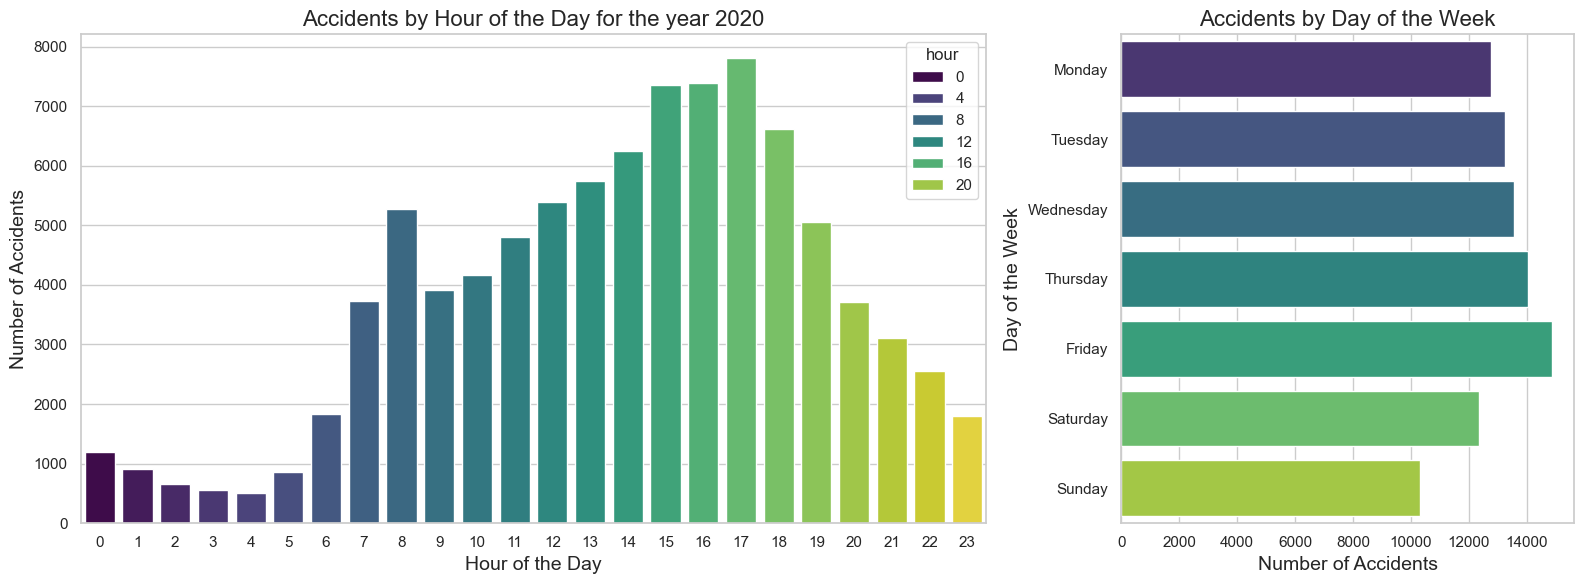

In [8]:
# Convert the 'date' column to datetime format
accident_table_df['date'] = pd.to_datetime(accident_table_df['date'], format='%d/%m/%Y')
# Extract the hour from the 'time' column
accident_table_df['hour'] = pd.to_datetime(accident_table_df['time'], format='%H:%M').dt.hour
# Convert 'day_of_week' to actual day names
day_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
               5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
accident_table_df['day_of_week_name'] = accident_table_df['day_of_week'].map(day_mapping)
# Group by hour and count occurrences
hourly_accidents = accident_table_df.groupby('hour').size().reset_index(name='count')
# Group by day of the week and count occurrences
daily_accidents = accident_table_df.groupby('day_of_week_name').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='count')
# Setting up the plotting environment
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})
# Plot accidents by hour
sns.barplot(ax=axes[0], x='hour', y='count', data=hourly_accidents, hue='hour', palette='viridis')
axes[0].set_title('Accidents by Hour of the Day for the year 2020', fontsize=16)
axes[0].set_xlabel('Hour of the Day', fontsize=14)
axes[0].set_ylabel('Number of Accidents', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
# Plot accidents by day of the week
sns.barplot(ax=axes[1], x='count', y='day_of_week_name', data=daily_accidents, hue ='day_of_week_name',palette='viridis')
axes[1].set_title('Accidents by Day of the Week', fontsize=16)
axes[1].set_xlabel('Number of Accidents', fontsize=14)
axes[1].set_ylabel('Day of the Week', fontsize=14)
axes[1].tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

***Motobike accident analysis***

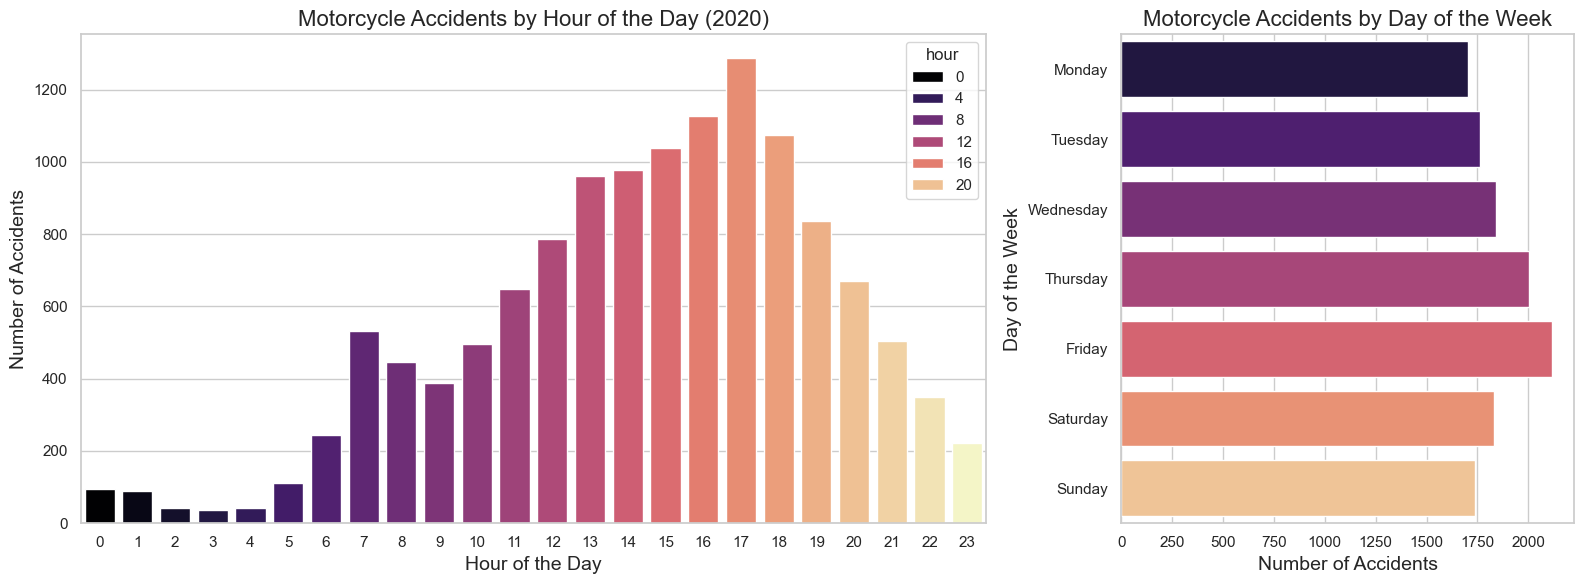

In [53]:
# Merge the accidents and vehicle tables on 'accident_index'
merged_df = pd.merge(accident_table_df, vehicle_table_df, on='accident_index')
# Filter for motorcycle accidents based on vehicle type
motorcycle_types = [3,4,5]
motorcycle_accidents_df = merged_df[merged_df['vehicle_type'].isin(motorcycle_types)].copy()
# Data preparation: convert 'time' to hour, and map 'day_of_week' to actual day names
motorcycle_accidents_df.loc[:, 'hour'] = pd.to_datetime(motorcycle_accidents_df['time'], format='%H:%M').dt.hour
day_mapping = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
               5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
motorcycle_accidents_df.loc[:, 'day_of_week_name'] = motorcycle_accidents_df['day_of_week'].map(day_mapping)
# Group by hour and count occurrences
hourly_motorcycle_accidents = motorcycle_accidents_df.groupby('hour').size().reset_index(name='count')
# Group by day of the week and count occurrences
daily_motorcycle_accidents = motorcycle_accidents_df.groupby('day_of_week_name').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='count')
# Setting up the plotting environment
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})
# Plot motorcycle accidents by hour (with hue)
sns.barplot(ax=axes[0], x='hour', y='count', data=hourly_motorcycle_accidents, hue='hour', palette='magma')
axes[0].set_title('Motorcycle Accidents by Hour of the Day (2020)', fontsize=16)
axes[0].set_xlabel('Hour of the Day', fontsize=14)
axes[0].set_ylabel('Number of Accidents', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
# Plot motorcycle accidents by day of the week (with hue)
sns.barplot(ax=axes[1], x='count', y='day_of_week_name', data=daily_motorcycle_accidents, hue='day_of_week_name', palette='magma')
axes[1].set_title('Motorcycle Accidents by Day of the Week', fontsize=16)
axes[1].set_xlabel('Number of Accidents', fontsize=14)
axes[1].set_ylabel('Day of the Week', fontsize=14)
axes[1].tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

***Pedestrian accidents analysis***

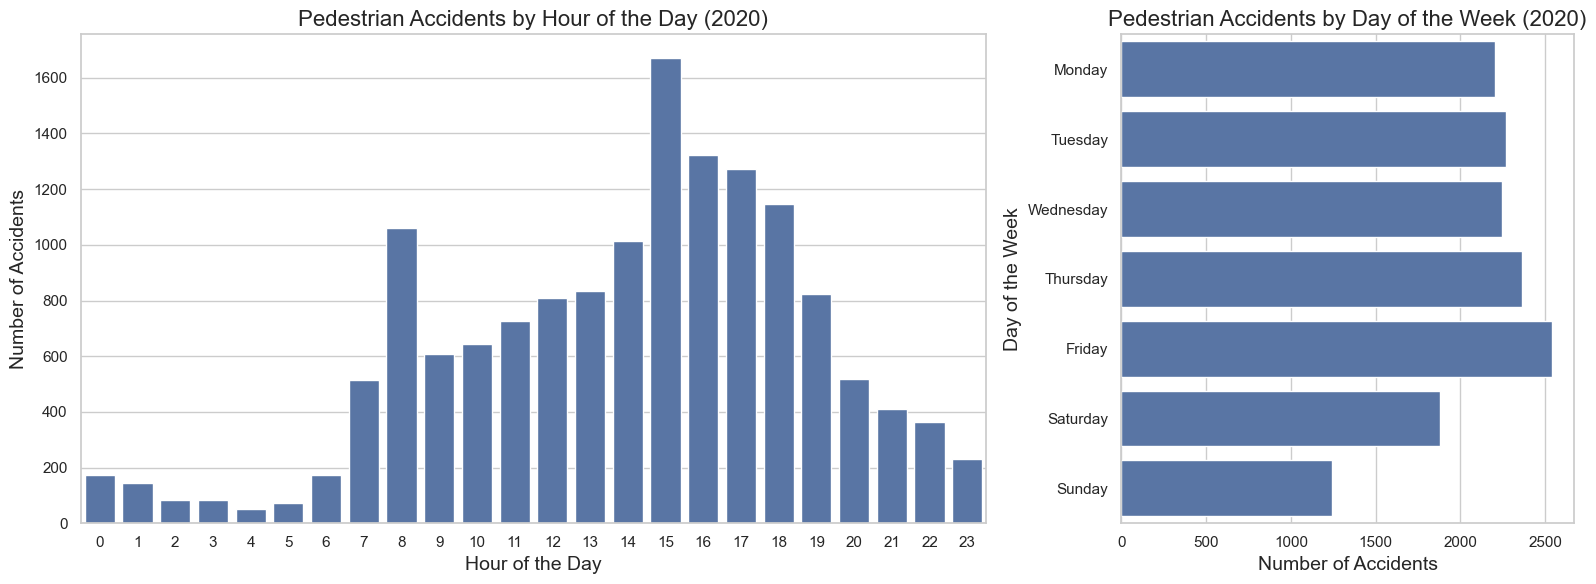

In [10]:
# This cell filters the data to focus exclusively on pedestrian accidents
# Merge the accidents and casualty tables on 'accident_index'
merged_casualty_df = pd.merge(accident_table_df, casualty_table_df, on='accident_index')
# Filter for pedestrian accidents based on casualty type
pedestrian_accidents_df = merged_casualty_df[merged_casualty_df['casualty_type'] == 0].copy()
# Extract hour and day information
pedestrian_accidents_df.loc[:, 'hour'] = pd.to_datetime(pedestrian_accidents_df['time'], format='%H:%M').dt.hour
pedestrian_accidents_df.loc[:, 'day_of_week_name'] = pedestrian_accidents_df['day_of_week'].map(day_mapping)
# Group by hour and count occurrences
hourly_pedestrian_accidents = pedestrian_accidents_df.groupby('hour').size().reset_index(name='count')
# Group by day of the week and count occurrences
daily_pedestrian_accidents = pedestrian_accidents_df.groupby('day_of_week_name').size().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index(name='count')
# Set up the plotting environment and create visualizations for the findings
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})
# Plot pedestrian accidents by hour of the day
sns.barplot(ax=axes[0], x='hour', y='count', data=hourly_pedestrian_accidents)
axes[0].set_title('Pedestrian Accidents by Hour of the Day (2020)', fontsize=16)
axes[0].set_xlabel('Hour of the Day', fontsize=14)
axes[0].set_ylabel('Number of Accidents', fontsize=14)
axes[0].tick_params(axis='x', rotation=0)
# Plot pedestrian accidents by day of the week
sns.barplot(ax=axes[1], x='count', y='day_of_week_name', data=daily_pedestrian_accidents)
axes[1].set_title('Pedestrian Accidents by Day of the Week (2020)', fontsize=16)
axes[1].set_xlabel('Number of Accidents', fontsize=14)
axes[1].set_ylabel('Day of the Week', fontsize=14)
axes[1].tick_params(axis='y', rotation=0)
plt.tight_layout()
plt.show()

***Apriori algorithm implementation***

In [11]:
# Prepare the data by selecting relevant features
selected_columns = ['accident_severity', 'road_type', 'weather_conditions', 'light_conditions', 'urban_or_rural_area']
df_apriori = accident_table_df[selected_columns].dropna()
# Encode the data using one-hot encoding and ensure it is binary
df_apriori_encoded = pd.get_dummies(df_apriori, drop_first=True)
# Any non-binary values will be corrected or removed
binary_columns = df_apriori_encoded.applymap(lambda x: 1 if x > 0 else 0)
# Applying the Apriori algorithm here
frequent_itemsets = apriori(binary_columns, min_support=0.2, use_colnames=True)
# Generating association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.6)
rules_sorted = rules.sort_values(by='lift', ascending=False)
# Displaying the top 10 rules with the highest lift
print("Top 10 Association Rules")
rules_sorted

Top 10 Association Rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
147,(light_conditions),"(road_type, urban_or_rural_area, weather_condi...",0.999989,0.999989,0.999989,1.000000,1.000011,0.000011,inf,1.0
41,(weather_conditions),"(light_conditions, accident_severity)",0.999989,0.999989,0.999989,1.000000,1.000011,0.000011,inf,1.0
88,"(accident_severity, weather_conditions)","(light_conditions, road_type)",0.999989,0.999989,0.999989,1.000000,1.000011,0.000011,inf,1.0
151,"(road_type, light_conditions, urban_or_rural_a...",(weather_conditions),0.999989,0.999989,0.999989,1.000000,1.000011,0.000011,inf,1.0
129,"(light_conditions, urban_or_rural_area)","(accident_severity, weather_conditions)",0.999989,0.999989,0.999989,1.000000,1.000011,0.000011,inf,1.0
...,...,...,...,...,...,...,...,...,...,...
63,"(road_type, weather_conditions)",(urban_or_rural_area),0.999989,1.000000,0.999989,1.000000,1.000000,0.000000,inf,0.0
64,"(road_type, urban_or_rural_area)",(weather_conditions),1.000000,0.999989,0.999989,0.999989,1.000000,0.000000,1.0,0.0
65,(weather_conditions),"(road_type, urban_or_rural_area)",0.999989,1.000000,0.999989,1.000000,1.000000,0.000000,inf,0.0
66,(urban_or_rural_area),"(road_type, weather_conditions)",1.000000,0.999989,0.999989,0.999989,1.000000,0.000000,1.0,0.0


***Accident distribution in Hambersside with Kmeans Clustering***

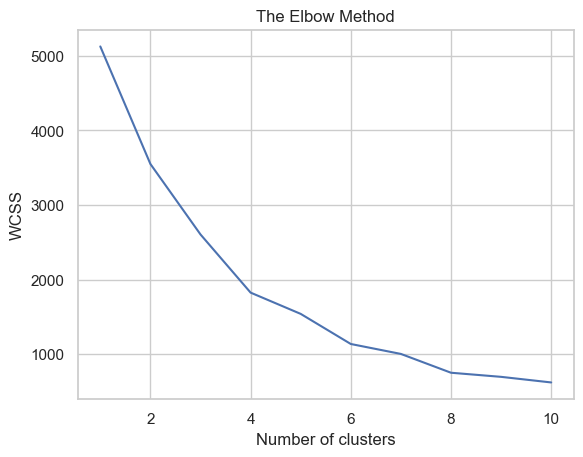

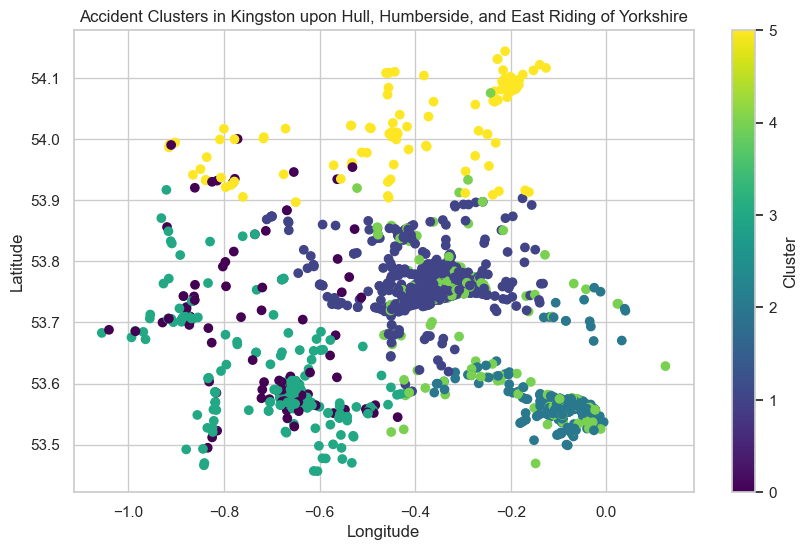

In [14]:
# Seleccting the region of interest which is Hamberside in our case
regions_of_interest = [16]
regional_accidents_df = accident_table_df[accident_table_df['police_force']==16]
# This cell extracts relevant features for clustering
features = regional_accidents_df[['longitude', 'latitude', 'accident_severity']].dropna()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(features)
inertial =[]
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(x_scaled)
    inertia = kmeans.inertia_
    inertial.append(inertia)
# Plotting to observe the elbow for the optimum clusters
plt.plot(range(1, 11), inertial)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
# Choose the number of clusters (k); for example, k=6
kmeans = KMeans(n_clusters=6, random_state=42)
regional_accidents_df['cluster'] = kmeans.fit_predict(x_scaled)
# This cell creates a scatter plot to visualize the clusters based on geographic coordinates
plt.figure(figsize=(10,6))
plt.scatter(regional_accidents_df['longitude'], regional_accidents_df['latitude'], c=regional_accidents_df['cluster'], cmap='viridis', marker='o')
plt.title('Accident Clusters in Kingston upon Hull, Humberside, and East Riding of Yorkshire')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

***Time series prediction of accidents***

In [41]:
# Querrying the accident table to get the records for the 2017-2019 accidents
query = """
        SELECT *
        FROM accident
        WHERE accident_year in(2017,2018,2019);
        """
# Read the data into a DataFrame
accident_table_ts = pd.read_sql_query(query, conn)
accident_table_ts

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,2017010001708,2017,010001708,532920.0,196330.0,-0.080107,51.650061,1,1,2,...,0,4,1,1,0,0,1,1,2,E01001450
1,2017010009342,2017,010009342,526790.0,181970.0,-0.173845,51.522425,1,3,2,...,0,4,1,2,0,0,1,1,2,E01004702
2,2017010009344,2017,010009344,535200.0,181260.0,-0.052969,51.514096,1,3,3,...,0,4,1,1,0,0,1,1,2,E01004298
3,2017010009348,2017,010009348,534340.0,193560.0,-0.060658,51.624832,1,3,2,...,4,4,2,2,0,0,1,1,2,E01001429
4,2017010009350,2017,010009350,533680.0,187820.0,-0.072372,51.573408,1,2,1,...,5,4,1,2,0,0,1,1,2,E01001808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370148,2019984106919,2019,984106919,312635.0,573392.0,-3.368899,55.047323,98,3,1,...,0,1,1,2,0,0,2,1,-1,-1
370149,2019984107019,2019,984107019,337522.0,591682.0,-2.983499,55.215407,98,3,4,...,0,1,1,2,0,0,2,1,-1,-1
370150,2019984107219,2019,984107219,318544.0,567087.0,-3.274645,54.991685,98,3,2,...,0,1,1,1,0,0,2,2,-1,-1
370151,2019984107419,2019,984107419,336525.0,584226.0,-2.997491,55.148292,98,3,1,...,0,1,1,1,0,0,2,2,-1,-1


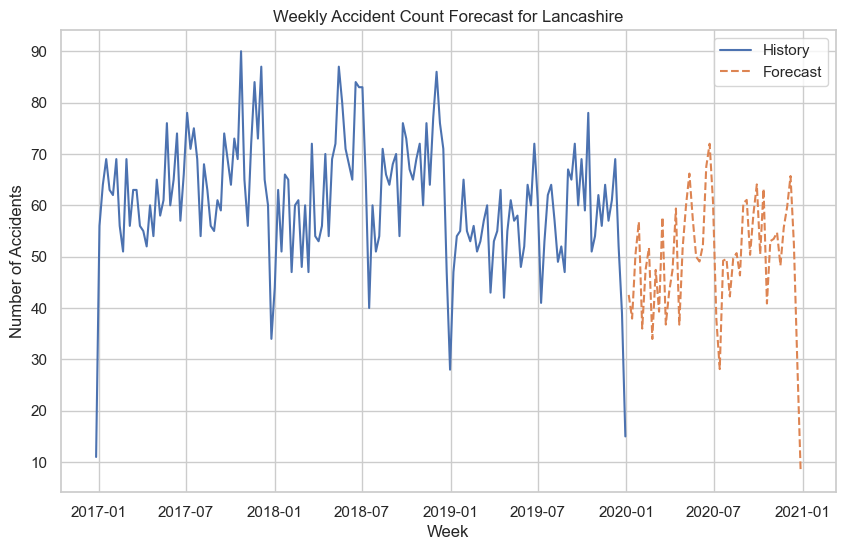

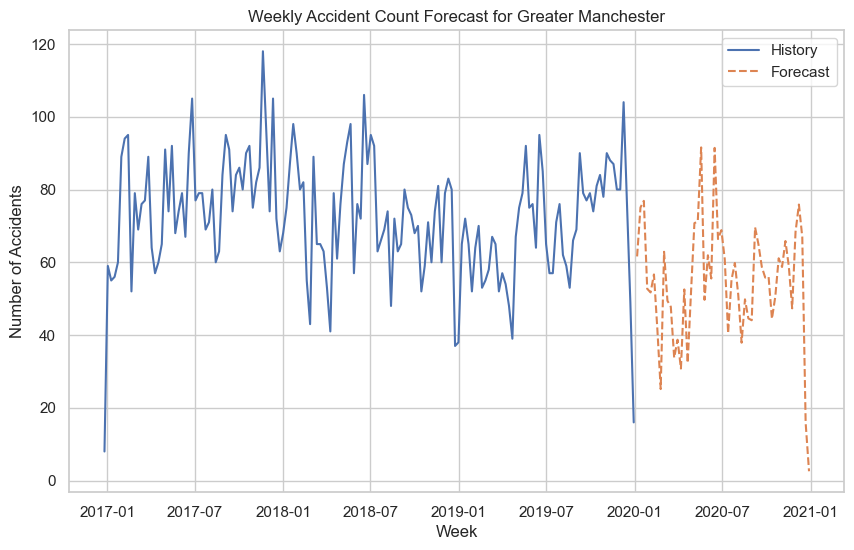

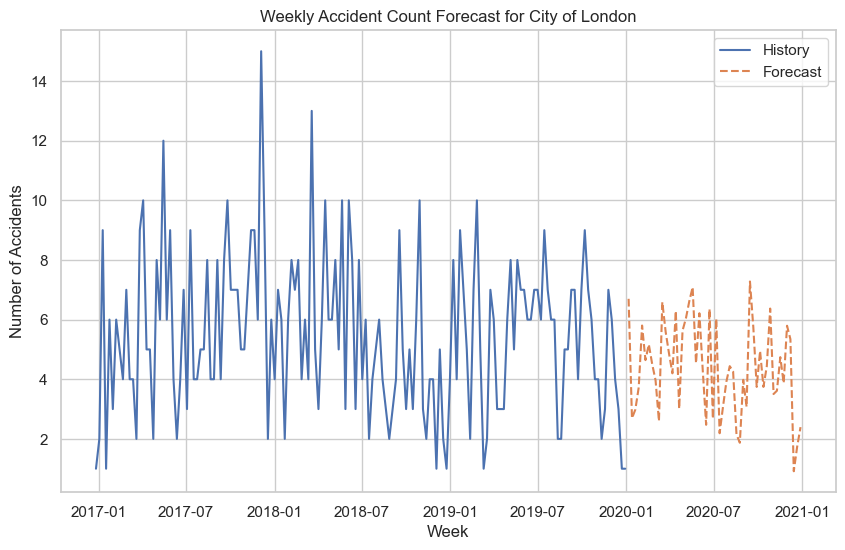

In [42]:
# Filter and prepare data for the selected policing areas
selected_policing_areas = {4:'Lancashire', 6:'Greater Manchester', 48:'City of London'}
time_series_data = {}

for area_number, area in selected_policing_areas.items():
    # Filter data for the selected area
    area_data = accident_table_ts[accident_table_ts['police_force'] == area_number]  
    # Aggregate accident counts by week
    area_data['week'] = pd.to_datetime(area_data['date'], format='%d/%m/%Y').dt.to_period('W').dt.start_time
    weekly_accidents = area_data.groupby('week').size()
    # Store the time series data
    time_series_data[area] = weekly_accidents
# Initialize a dictionary to store the forecasts
predictions = {}
# SARIMA parameters: p, d, q for non-seasonal; P, D, Q for seasonal; s for seasonal period
p, d, q = (1, 1, 1)
# Seasonal order with yearly seasonality (s=52 for weekly data)
P, D, Q, s = (1, 1, 1, 52)  

for area, ts in time_series_data.items():
    # Ensure the time series data is numeric and without missing values
    ts = pd.to_numeric(ts, errors='coerce').fillna(0)
    # Fit the SARIMA model
    model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    # Forecast the next 52 weeks (1 year)
    forecast = model_fit.get_forecast(steps=52).predicted_mean
    predictions[area] = forecast
    # Plot the actual vs forecasted accidents
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index, ts.values, label='History')
    plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
    plt.title(f'Weekly Accident Count Forecast for {area}')
    plt.xlabel('Week')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.show()

***Three Super output areas***

In [30]:
query = """
SELECT lsoa01cd, lsoa01nm, COUNT(lsoa_of_accident_location) AS number_of_accidents
FROM accident
JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE strftime('%Y-%m-%d', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) 
      BETWEEN '2020-01-01' AND '2020-03-31'
AND lsoa01nm LIKE '% Hull %'
GROUP BY lsoa01cd, lsoa01nm
ORDER BY number_of_accidents DESC
LIMIT 3;
"""
# Execute the query and load the results into a DataFrame
top_lsoas_df = pd.read_sql_query(query, conn)
top_lsoas_df

,lsoa01cd,lsoa01nm,number_of_accidents
0,E01012817,Kingston upon Hull 016D,10
1,E01012848,Kingston upon Hull 020B,7
2,E01012889,Kingston upon Hull 030B,7


Processing LSOA: E01012817
Total number of accidents for LSOA E01012817 from January to June 2020: 13
Processing LSOA: E01012848
Total number of accidents for LSOA E01012848 from January to June 2020: 9
Processing LSOA: E01012855
Total number of accidents for LSOA E01012855 from January to June 2020: 8


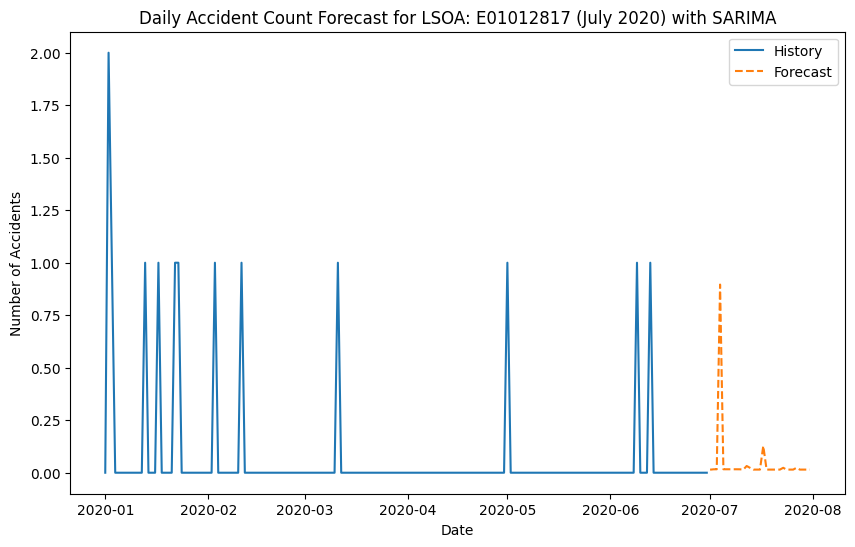

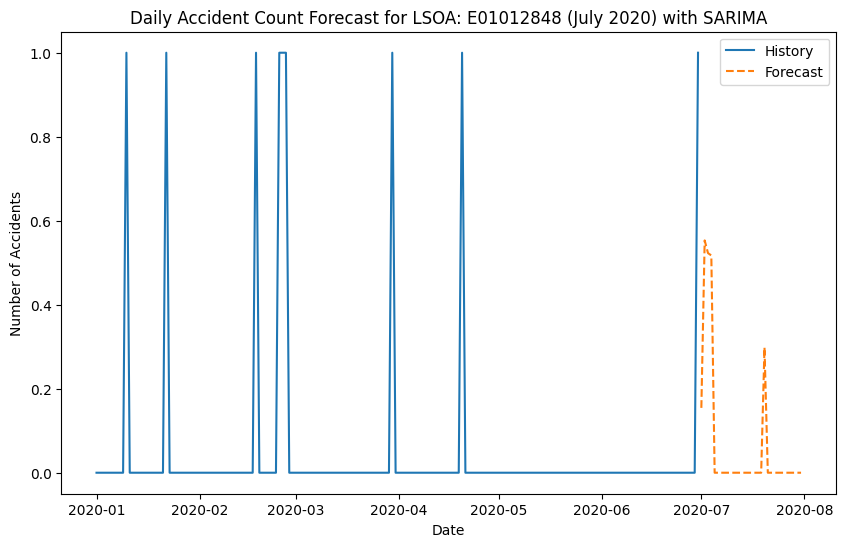

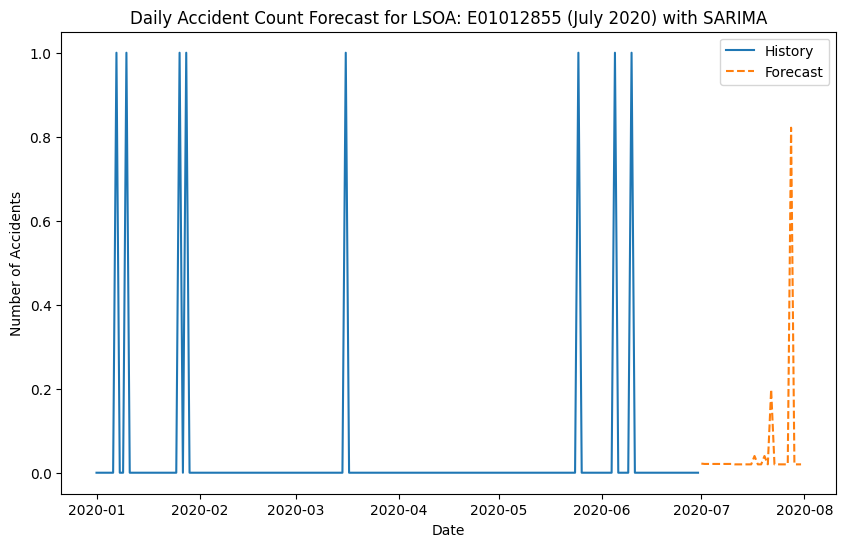

In [10]:
# Initialize a dictionary to store the time series data for each LSOA
time_series_data = {}
# Looping through the lsoa codes above and populating the timeseries data for the predictions
for index, row in top_lsoas_df.iterrows():
    lsoa_code = row['lsoa01cd']
    print(f"Processing LSOA: {lsoa_code}")
    
    # SQL query to get daily accident counts for the specified LSOA in 2020
    query = f"""
    SELECT date, COUNT(*) AS daily_accidents
    FROM accident
    WHERE lsoa_of_accident_location = '{lsoa_code}'
        AND strftime('%Y-%m-%d', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2))
        BETWEEN '01-01-2020' AND '30-06-2020'
    GROUP BY date
    ORDER BY date;
    """

    # Execute the query and load the results into a DataFrame
    daily_accidents_df = pd.read_sql_query(query, conn)
    # Convert the date column to datetime format and set it as the index
    daily_accidents_df['date'] = pd.to_datetime(daily_accidents_df['date'], format='%d/%m/%Y')
    daily_accidents_df.set_index('date', inplace=True)
    # Ensure daily frequency and fill missing days with 0
    daily_accidents_df = daily_accidents_df.asfreq('D', fill_value=0)  
    # Explicitly filter the DataFrame to keep only the 2020 dates
    daily_accidents_df = daily_accidents_df['01-01-2020':'30-06-2020']
    # Store the time series data
    time_series_data[lsoa_code] = daily_accidents_df['daily_accidents']
    # Calculate and print the total number of accidents for the LSOA
    total_accidents = daily_accidents_df['daily_accidents'].sum()
    print(f"Total number of accidents for LSOA {lsoa_code} from January to June 2020: {total_accidents}")

# Initialize a dictionary to store the forecasts
forecasts = {}
# SARIMA parameters: p, d, q for non-seasonal; P, D, Q for seasonal; s for seasonal period
p, d, q = (1, 1, 1)  # Non-seasonal order
P, D, Q, s = (1, 1, 1, 64)  # Seasonal order with weekly seasonality (s=7)

for lsoa_code, ts in time_series_data.items():
    # Ensure the time series data is numeric and without missing values
    ts = pd.to_numeric(ts, errors='coerce').fillna(0)
    # Fit the SARIMA model
    model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    # Forecast daily accidents for July 2020 (31 days)
    forecast = model_fit.get_forecast(steps=31).predicted_mean
    # Ensure non-negative forecast values
    forecast[forecast < 0] = 0
    forecasts[lsoa_code] = forecast
    # Plot the actual vs forecasted accidents
    plt.figure(figsize=(10, 6))
    plt.plot(ts.index, ts.values, label='History')
    plt.plot(pd.date_range(start='2020-07-01', periods=31), forecast, label='Forecast', linestyle='--')
    plt.title(f'Daily Accident Count Forecast for LSOA: {lsoa_code} (July 2020) with SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Number of Accidents')
    plt.legend()
    plt.show()

***Social Network Construction and Basic Network Characteristics***

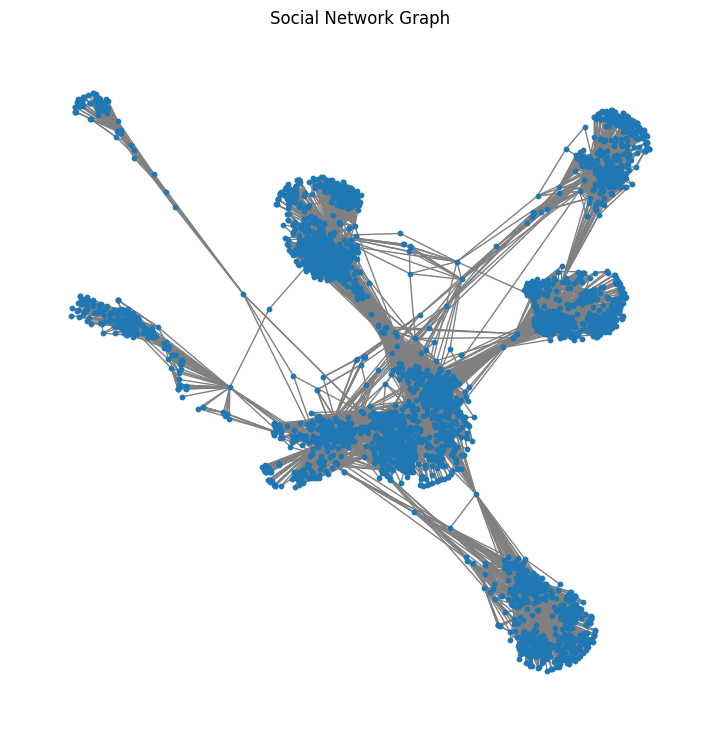

Number of nodes: 4039
Number of edges: 88234
Network density: 0.0108
Average degree: 43.69


In [8]:
# Loading the social network data
edges = pd.read_csv('facebook_combined.txt', delim_whitespace=True, header=None, names=['source', 'target'])
# Construct the network graph
G = nx.from_pandas_edgelist(edges, source='source', target='target')
# Visualize the network (this might be dense, so it's best for smaller networks)
plt.figure(figsize=(7, 7))
nx.draw(G, node_size=10, edge_color='grey')
plt.title('Social Network Graph')
plt.show()
#Calculate basic network characteristics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
average_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Network density: {density:.4f}")
print(f"Average degree: {average_degree:.2f}")


***Edge Centrality Calculation and Distribution Plot***

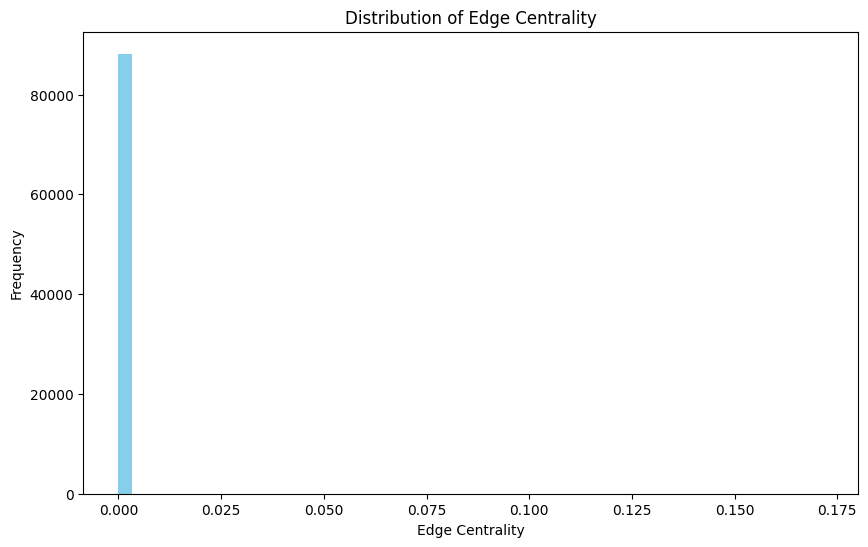

Edge Centrality - Max: 0.17149343710907303
Edge Centrality - Min: 1.2262805158373514e-07
Edge Centrality - Mean: 4.1849024748922135e-05


In [9]:
# Calculate edge betweenness centrality
edge_centrality = nx.edge_betweenness_centrality(G)

# Plot the distribution of edge centrality values
plt.figure(figsize=(10, 6))
plt.hist(list(edge_centrality.values()), bins=50, color='skyblue')
plt.title('Distribution of Edge Centrality')
plt.xlabel('Edge Centrality')
plt.ylabel('Frequency')
plt.show()

# Output some basic statistics about edge centrality
print(f"Edge Centrality - Max: {max(edge_centrality.values())}")
print(f"Edge Centrality - Min: {min(edge_centrality.values())}")
print(f"Edge Centrality - Mean: {sum(edge_centrality.values())/len(edge_centrality)}")


***Community Detection and Comparison***


Louvain Method:
Number of communities: 16
Number of nodes in each community: [350, 430, 19, 423, 535, 323, 129, 435, 548, 73, 237, 25, 61, 206, 19, 226]

Label Propagation Method:
Number of communities: 44
Number of nodes in each community: [198, 36, 10, 8, 8, 34, 2, 215, 16, 3, 3, 1030, 6, 7, 3, 3, 753, 10, 2, 2, 469, 13, 9, 3, 49, 25, 2, 60, 547, 179, 10, 9, 8, 226, 19, 4, 3, 8, 6, 14, 12, 7, 6, 2]


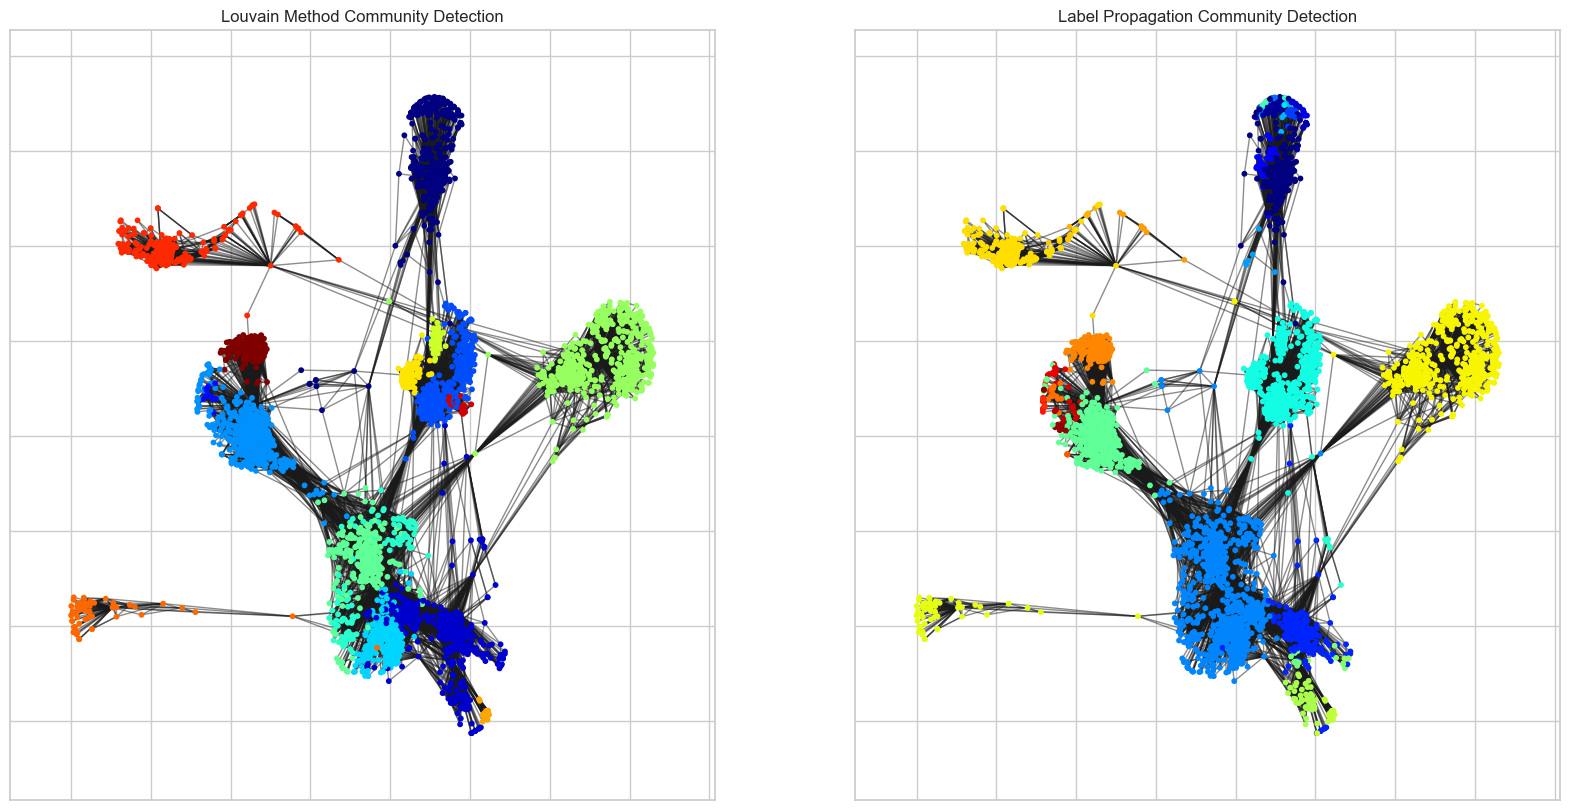

In [47]:
# Define the community detection algorithms
community_algorithms = {
    "Louvain": lambda G: community_louvain.best_partition(G),
    "Label Propagation": lambda G: list(nx_comm.label_propagation_communities(G))
}

# Apply each algorithm and store the results
community_results = {}
for name, algorithm in community_algorithms.items():
    if name == "Louvain":
        partition = algorithm(G)
        num_communities = len(set(partition.values()))
        nodes_in_clusters = [list(partition.values()).count(i) for i in set(partition.values())]
        community_results[name] = {
            "partition": partition,
            "num_communities": num_communities,
            "nodes_in_clusters": nodes_in_clusters
        }
    else:  # Label Propagation
        communities = algorithm(G)
        num_communities = len(communities)
        nodes_in_clusters = [len(community) for community in communities]
        community_results[name] = {
            "communities": communities,
            "num_communities": num_communities,
            "nodes_in_clusters": nodes_in_clusters
        }

# Comparing the results of these two community detection algorithm
for name, result in community_results.items():
    print(f"\n{name} Method:")
    print(f"Number of communities: {result['num_communities']}")
    print(f"Number of nodes in each community: {result['nodes_in_clusters']}")

#  Visualize both Louvain and Label Propagation community structures
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Louvain visualization
pos = nx.spring_layout(G)
louvain_partition = community_results["Louvain"]["partition"]
nx.draw_networkx_nodes(G, pos, ax=axes[0], node_size=10, cmap=plt.cm.jet, node_color=list(louvain_partition.values()))
nx.draw_networkx_edges(G, pos, ax=axes[0], alpha=0.5)
axes[0].set_title('Louvain Method Community Detection')

# Label Propagation visualization
label_communities = community_results["Label Propagation"]["communities"]
label_color_map = {}
for i, community in enumerate(label_communities):
    for node in community:
        label_color_map[node] = i
node_colors = [label_color_map[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, ax=axes[1], node_size=10, cmap=plt.cm.jet, node_color=node_colors)
nx.draw_networkx_edges(G, pos, ax=axes[1], alpha=0.5)
axes[1].set_title('Label Propagation Community Detection')
plt.show()
